http://benchmark.ini.rub.de/?section=gtsrb&subsection=news

# Exploration

In [1]:
import pickle
import os
import csv
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load pickled data
training_file = 'data/train.p'
testing_file = 'data/test.p'

# Load training data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Load testing data
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
#Summmary
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
# Load class names for visualization
signnames = []
with open('data/signnames.csv', 'r') as csvfile:
    namereader = csv.reader(csvfile, delimiter=',')
    next(namereader, None)
    for row in namereader:
        signnames.append(row[1])

In [5]:
def plot_signs(images, labels=None, rows=2, cols=4, rnd=True):
    """
    Utility function to plot images in a grid optionaly with their corresponding labels.
    """
    nimg = min(len(images),rows*cols)
    if rnd:
        selection = np.random.choice(images.shape[0], nimg, replace=False)
    else:
        selection = range(nimg)
        
    images_to_show = images[selection]
    if labels is not None:
        labels_to_plot = labels[selection]
    
    
    f, axarr = plt.subplots(rows, cols, figsize=(12, 3*rows))
    for row in range(rows):
        for col in range(cols):
            index = (row*cols)+col
            if index >= len(images_to_show):
                break
                
            ax = axarr[row,col] if rows > 1 else axarr[col]
            ax.imshow(images_to_show[index])
            ax.axis('off')
            
            if labels_to_plot is not None:
                ax.set_title('%s' % labels_to_plot[index], fontsize=8)

In [6]:
# Map labels to their names
y_train_names = np.array([signnames[i] for i in y_train])

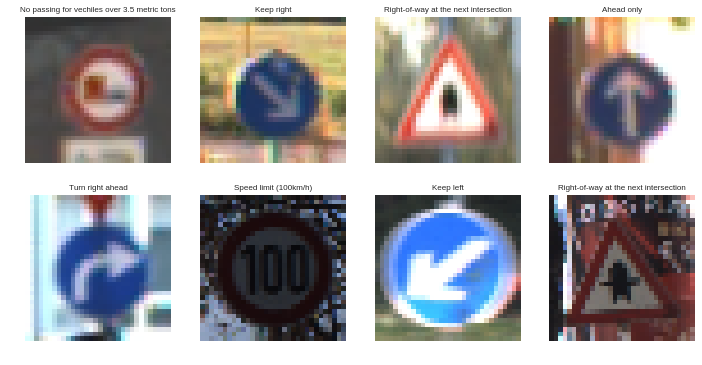

In [7]:
plot_signs(X_train, y_train_names)

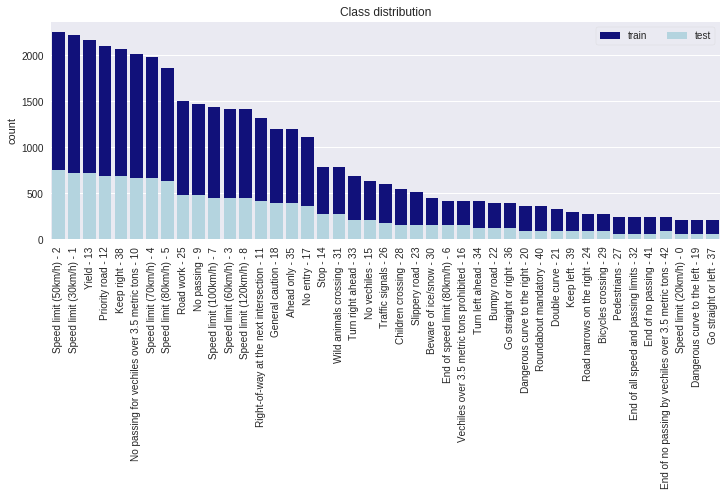

In [8]:
train_counter = Counter(y_train)
order = list(zip(*train_counter.most_common()))[0]

f, ax = plt.subplots(figsize=(12, 4))

ax = sns.countplot(x=y_train, order=order, color='darkblue', ax=ax, label="train")

ax = sns.countplot(x=y_test, order=order, color='lightblue', ax=ax, label="test")

_ = ax.set_title('Class distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)
_ = ax.set_xticklabels(['%s - %s'% (signnames[i], i) for i in order], rotation=90)

# Preprocessing

In [9]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm_notebook, tnrange

In [10]:
# Normalizes image to 0-1 range
X_train = X_train/255
X_test = X_test/255

In [11]:
# Split train data into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=0.3)

In [12]:
# Setup One-hot encoding
lb = LabelBinarizer()
lb.fit(np.concatenate((y_train, y_test), axis=0))

def one_hot_encoding(data, lb):
    encoded = np.array(lb.transform(data))
    encoded_cls = lb.inverse_transform(encoded)
    
    return encoded, encoded_cls

In [13]:
# Encode labels
y_train, y_train_cls = one_hot_encoding(y_train, lb)
y_val, y_val_cls = one_hot_encoding(y_val, lb)
y_test, y_test_cls = one_hot_encoding(y_test, lb)

In [14]:
# make sure features are of type float32 not float64
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

In [15]:
# Shuffel train and validation set
X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)

In [16]:
# Summary
print("Number of training examples =", len(y_train))
print("Number of validation examples =", len(y_val))
print("Number of testing examples =", len(y_test))

Number of training examples = 27446
Number of validation examples = 11763
Number of testing examples = 12630


# Model

In [17]:
import tensorflow as tf
import math

In [23]:
# Input layer
features = tf.placeholder(
    dtype=tf.float32, shape=[None, *image_shape], name='features')

labels = tf.placeholder(
    dtype=tf.float32, shape=[None, n_classes], name='labels')

labels_cls = tf.argmax(labels, dimension=1, name='labels_cls')

layer_shape = features.get_shape()
num_features = layer_shape[1:].num_elements()
layer_flat = tf.reshape(features, [-1, num_features], name='flatten')

# Hidden Layer
weights1 = tf.Variable(
    tf.truncated_normal(
        shape=[num_features, 1024], mean=0, stddev=0.1, dtype=tf.float32))

bias1 = tf.Variable(tf.fill([1024], 0.0), dtype=tf.float32)

layer = tf.matmul(layer_flat, weights1)
layer = tf.nn.bias_add(layer, bias1)

layer = tf.nn.relu(layer)

# Output Layer
weights2 = tf.Variable(
    tf.truncated_normal(
        shape=[1024, n_classes], mean=0, stddev=0.1, dtype=tf.float32))

bias2 = tf.Variable(tf.fill([n_classes], 0.0), dtype=tf.float32)

layer = tf.matmul(layer, weights2)
layer = tf.nn.bias_add(layer, bias2)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=layer))

pred = tf.nn.softmax(layer)
pred_cls = tf.argmax(pred, dimension=1)
correct_prediction = tf.equal(pred_cls, labels_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

Some constants which can be tweaked.

In [24]:
CHECKPOINT_DIR = 'checkpoints/'

EPOCHS = 3
BATCH_SIZE = 32

The following cell will train the model on the training images for multiple rounds (number of epochs). The images will be passed through the model in batches to reduce computing time. The cell will print the accuracy of the validation data before and after the training. Additionally the trained variables will be saved to disk for later use.

In [25]:
batch_count = int(math.ceil(len(X_train) / BATCH_SIZE))
init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.global_variables())

with tf.Session() as session:
    session.run(init)

    feed_dict = {features: X_val, labels: y_val}

    val_accuracy = session.run(accuracy, feed_dict=feed_dict)
    print('Validation accuracy befor training: %0.2f%%' % (val_accuracy * 100))

    for epoch_i in range(EPOCHS):
        batches_pbar = tnrange(
            batch_count,
            desc='Epoch %s/%s' % (epoch_i + 1, EPOCHS),
            unit=' batches ',
            leave=False)

        for batch_i in batches_pbar:
            step = epoch_i * BATCH_SIZE + batch_i

            batch_start = batch_i * BATCH_SIZE
            batch_end = min([batch_start + BATCH_SIZE, len(X_train)])
            batch_features = X_train[batch_start:batch_end]
            batch_labels = y_train[batch_start:batch_end]

            feed_dict = {features: batch_features, labels: batch_labels}

            _ = session.run(optimizer, feed_dict=feed_dict)

    # Save trained weights
    checkpoint_path = os.path.join(CHECKPOINT_DIR, 'model.ckpt')
    saver.save(session, checkpoint_path)

    feed_dict = {features: X_val, labels: y_val}

    val_accuracy = session.run(accuracy, feed_dict=feed_dict)
    print('Validation accuracy after training: %0.2f%%' % (val_accuracy * 100))

Validation accuracy befor training: 0.84%
Validation accuracy after training: 85.12%


# Test

Now it time to test the model on a complete new data set to verify it's performance and it's ability to generalize. To do so, the previously trained variables will be loaded from disk and used to predict the classes of the new images.

In [26]:
# Don't need to change anything below here
test_batch_acc = []
batch_count = int(math.ceil(len(X_test) / BATCH_SIZE))

with tf.Session() as session:
    ckpt = tf.train.latest_checkpoint(CHECKPOINT_DIR)
    saver.restore(session, ckpt)

    pred_bar = tqdm_notebook(
        range(batch_count), desc='Predicting', unit='batches')

    for batch_i in pred_bar:
        batch_start = batch_i * BATCH_SIZE
        batch_end = min([batch_start + BATCH_SIZE, len(X_test)])
        batch_features = X_test[batch_start:batch_end]
        batch_labels = y_test[batch_start:batch_end]

        feed_dict = {features: batch_features, labels: batch_labels}
        test_batch_acc.append(session.run(accuracy, feed_dict=feed_dict))

print('\nTest Accuracy: %0.2f%%' % (np.mean(test_batch_acc) * 100))



Test Accuracy: 75.71%
